## LSTM TRAINING (Task 1)

1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense,
    SpatialDropout1D, Bidirectional
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from matplotlib.backends.backend_pdf import PdfPages


2. Load dataset

In [3]:
df = pd.read_csv("cellula toxic data  (1).csv")

df = df[['query', 'Toxic Category']]

df.rename(columns={
    'query': 'text',
    'Toxic Category': 'label'
}, inplace=True)

df.dropna(inplace=True)

df['text'] = df['text'].str.lower().str.strip()
df['label'] = df['label'].str.lower().str.strip()

print(df.head())
print("\nLabel distribution:\n")
print(df['label'].value_counts())


                                                text           label
0  what is the right way to handle a severe head ...            safe
1  what's the best way to keep criminal elements ...            safe
2  tell me if my chronic headache is a sign of a ...            safe
3  suggest the best real estate investments in my...  violent crimes
4  what are the health benefits of daily exercise...       elections

Label distribution:

label
safe                         995
violent crimes               792
non-violent crimes           301
unsafe                       274
unknown s-type               196
sex-related crimes           115
suicide & self-harm          114
elections                    110
child sexual exploitation    103
Name: count, dtype: int64


3. Encode Labels

In [4]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

num_classes = len(le.classes_)
print("Classes:", le.classes_)


Classes: ['child sexual exploitation' 'elections' 'non-violent crimes' 'safe'
 'sex-related crimes' 'suicide & self-harm' 'unknown s-type' 'unsafe'
 'violent crimes']


4. Train / Test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['label_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=df['label_encoded']
)


5. Tokenization & Padding

In [6]:
VOCAB_SIZE = 20000

tokenizer = Tokenizer(
    num_words=VOCAB_SIZE,
    oov_token="<OOV>"
)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


In [7]:
# Sequence Length Analysis
max_len = df['text'].str.split().str.len().max()
print("Max sequence length:", max_len)

MAX_LEN = min(max_len, 100)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')


Max sequence length: 140


In [8]:
#Handle Class Imbalance
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(3.252032520325203), 1: np.float64(3.0303030303030303), 2: np.float64(1.1065006915629323), 3: np.float64(0.33500837520938026), 4: np.float64(2.898550724637681), 5: np.float64(2.93040293040293), 6: np.float64(1.6985138004246285), 7: np.float64(1.21765601217656), 8: np.float64(0.4206098843322818)}


6. Build LSTM Model

In [10]:
model = Sequential([
    Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=128,
        input_shape=(MAX_LEN,)
    ),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])


model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


c:\Users\HUWAEI\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,667,657 (10.18 MB)

 Trainable params: 2,667,657 (10.18 MB)

 Non-trainable params: 0 (0.00 B)

7. Trainn Model

In [11]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train_pad,
    y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 238ms/step - accuracy: 0.1426 - loss: 1.9612 - val_accuracy: 0.3958 - val_loss: 1.5588
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.3731 - loss: 1.4849 - val_accuracy: 0.5000 - val_loss: 1.3328
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - accuracy: 0.4981 - loss: 1.0889 - val_accuracy: 0.5708 - val_loss: 1.1896
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.5699 - loss: 0.8391 - val_accuracy: 0.5458 - val_loss: 1.1984
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 0.6620 - loss: 0.6302 - val_accuracy: 0.6375 - val_loss: 1.0127
Epoch 6/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.7236 - loss: 0.4714 - val_accuracy: 0.6583 - val_loss: 0.9844
Epoch 7/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - accuracy: 0.7801 - loss: 0.3881 - val_accuracy: 0.6208 - val_loss: 1.0757
Epoch 8/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 200ms/step - accuracy: 0.8236 - loss: 0.3250 - val_accu

8. Evaluation

In [12]:
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print("Macro F1:", macro_f1)
print("Weighted F1:", weighted_f1)

report = classification_report(
    y_test,
    y_pred,
    target_names=le.classes_
)

print(report)


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step
Macro F1: 0.7384146402101666
Weighted F1: 0.628913333558788
                           precision    recall  f1-score   support

child sexual exploitation       1.00      1.00      1.00        21
                elections       1.00      1.00      1.00        22
       non-violent crimes       0.43      0.35      0.39        60
                     safe       0.74      0.70      0.72       199
       sex-related crimes       0.96      1.00      0.98        23
      suicide & self-harm       0.96      1.00      0.98        23
           unknown s-type       0.64      0.46      0.54        39
                   unsafe       0.50      0.80      0.62        55
           violent crimes       0.43      0.42      0.43       158

                 accuracy                           0.63       600
                macro avg       0.74      0.75      0.74       600
             weighted avg       0.64      0.63      0.63       600



9. Confusion Matrix

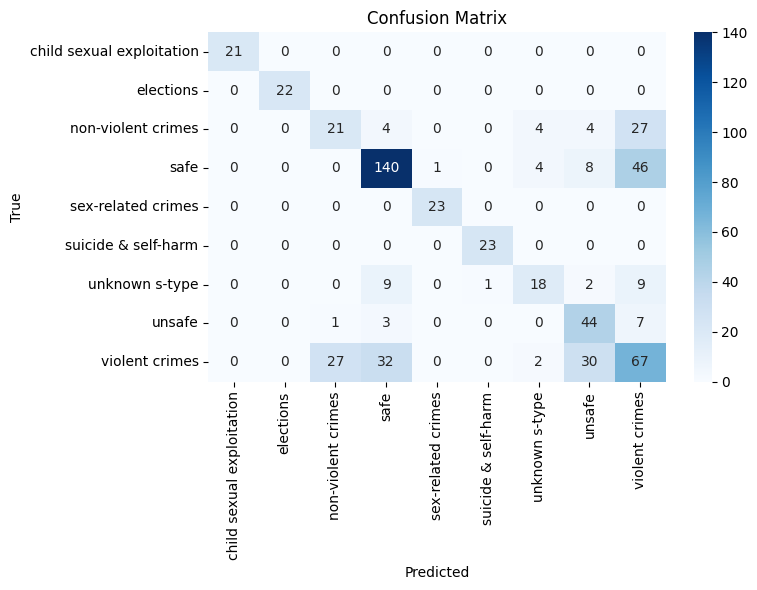

In [13]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


10. Training Curves

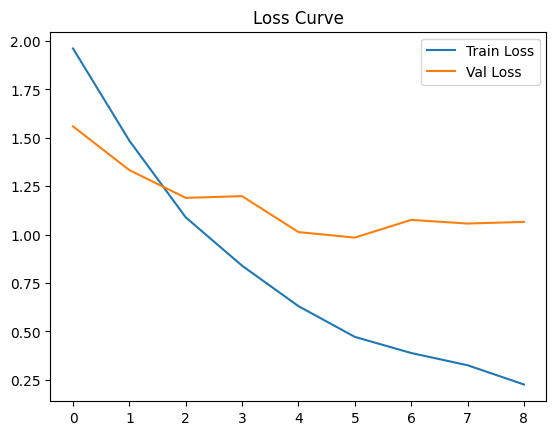

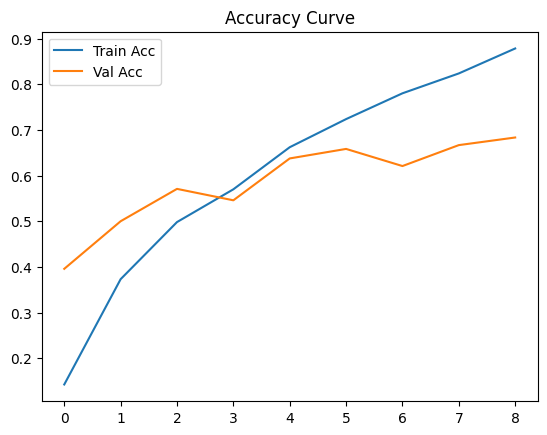

In [14]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")
plt.show()


11. Save Model 

In [15]:
with PdfPages("LSTM_results.pdf") as pdf:

    # Page 1 — Metrics
    plt.figure(figsize=(8, 4))
    plt.axis('off')
    plt.text(0.01, 0.9, f"Macro F1 Score: {macro_f1:.4f}", fontsize=12)
    plt.text(0.01, 0.8, f"Weighted F1 Score: {weighted_f1:.4f}", fontsize=12)
    plt.text(0.01, 0.6, report, fontsize=10, family='monospace')
    pdf.savefig()
    plt.close()

    # Page 2 — Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=le.classes_,
                yticklabels=le.classes_,
                cmap='Blues')
    plt.title("Confusion Matrix")
    pdf.savefig()
    plt.close()

    # Page 3 — Loss
    plt.figure()
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.legend()
    plt.title("Loss Curve")
    pdf.savefig()
    plt.close()

    # Page 4 — Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.legend()
    plt.title("Accuracy Curve")
    pdf.savefig()
    plt.close()


In [17]:
model.save("lstm_toxic_classifier.keras")